In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import joblib

class ModelTrainer:
    def __init__(self, model, encoder=None):
        self.model = model
        self.encoder = encoder if encoder else OneHotEncoder(sparse_output=False)

    def prepare_data(self, df, features, targets):
        X = df[features]
        y = df[targets]

        # One-hot encode categorical features if necessary
        if 'Function Name' in features:
            X_encoded = self.encoder.fit_transform(X[['Function Name']])
            X_encoded = pd.DataFrame(X_encoded, columns=self.encoder.get_feature_names_out(['Function Name']))
            X_encoded['Input Feature'] = X['Input Feature'].values
            X = X_encoded

        return X, y

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def save_model(self, model_path):
        joblib.dump(self.model, model_path)

    def save_encoder(self, encoder_path):
        joblib.dump(self.encoder, encoder_path)

    def load_model(self, model_path):
        self.model = joblib.load(model_path)

    def load_encoder(self, encoder_path):
        self.encoder = joblib.load(encoder_path)

    @staticmethod
    def evaluate(y_true, y_pred):
        from sklearn.metrics import mean_squared_error
        mse = mean_squared_error(y_true, y_pred)
        print(f"MSE: {mse}")

    


In [22]:

from sklearn.ensemble import RandomForestRegressor
import os

# Create 'models' directory if it does not exist
models_dir = 'modelss'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)


# Assuming ModelTrainer class definition is already provided as above

# Load your dataset
df = pd.read_csv('./logs/Nimbus500_v1.csv')

# Split your dataset
train_df = df.iloc[:1200]
test_df = df.iloc[1200:]

# Define features and targets
features = ['Function Name', 'Input Feature']
target_duration = 'Duration'
target_cpu_usage = 'Max CPU Usage'
target_memory_usage = 'Max Memory Usage'

# Initialize the model trainers for each prediction target
trainer_duration = ModelTrainer(RandomForestRegressor(random_state=42))
trainer_cpu_usage = ModelTrainer(RandomForestRegressor(random_state=42))
trainer_memory_usage = ModelTrainer(RandomForestRegressor(random_state=42))

# Prepare the data for each target
X_train, y_train_duration = trainer_duration.prepare_data(train_df, features, [target_duration])
X_test, y_test_duration = trainer_duration.prepare_data(test_df, features, [target_duration])

_, y_train_cpu_usage = trainer_cpu_usage.prepare_data(train_df, features, [target_cpu_usage])
_, y_test_cpu_usage = trainer_cpu_usage.prepare_data(test_df, features, [target_cpu_usage])

_, y_train_memory_usage = trainer_memory_usage.prepare_data(train_df, features, [target_memory_usage])
_, y_test_memory_usage = trainer_memory_usage.prepare_data(test_df, features, [target_memory_usage])

# Fit the models
trainer_duration.fit(X_train, y_train_duration)
trainer_cpu_usage.fit(X_train, y_train_cpu_usage)
trainer_memory_usage.fit(X_train, y_train_memory_usage)

# Predict and evaluate
y_pred_duration = trainer_duration.predict(X_test)
trainer_duration.evaluate(y_test_duration, y_pred_duration)

y_pred_cpu = trainer_cpu_usage.predict(X_test)
trainer_cpu_usage.evaluate(y_test_cpu_usage, y_pred_cpu)

y_pred_memory = trainer_memory_usage.predict(X_test)
trainer_memory_usage.evaluate(y_test_memory_usage, y_pred_memory)


trainer_duration.save_model(os.path.join(models_dir, 'model_duration.pkl'))
trainer_duration.save_encoder(os.path.join(models_dir, 'encoder_duration.pkl'))

trainer_cpu_usage.save_model(os.path.join(models_dir, 'model_cpu_usage.pkl'))
trainer_cpu_usage.save_encoder(os.path.join(models_dir, 'encoder_cpu_usage.pkl'))

trainer_memory_usage.save_model(os.path.join(models_dir, 'model_memory_usage.pkl'))
trainer_memory_usage.save_encoder(os.path.join(models_dir, 'encoder_memory_usage.pkl'))



/home/peiman/miniconda3/envs/nimbus/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/peiman/miniconda3/envs/nimbus/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/peiman/miniconda3/envs/nimbus/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MSE: 2339718.250245587
MSE: 3.887166218071022
MSE: 0.4135208919402386


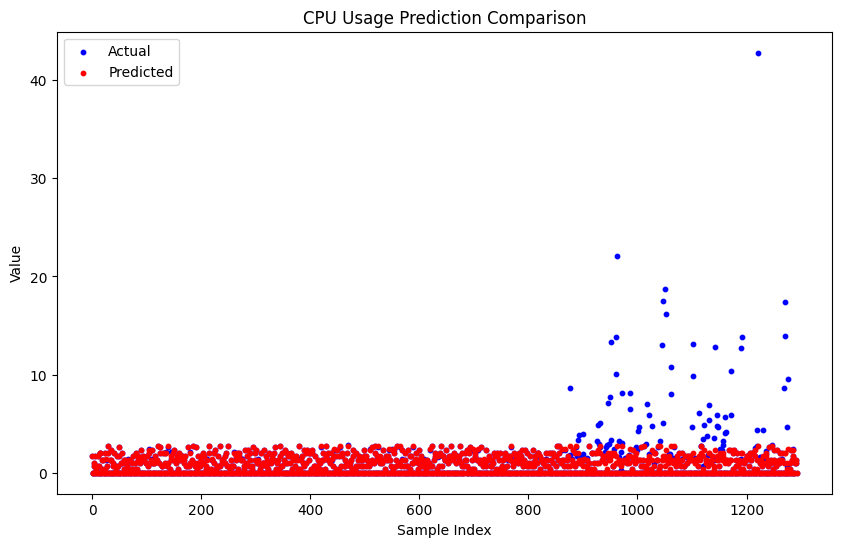

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def ensure_1d_array(data):
    """
    Ensure the data is a 1-dimensional numpy array.
    
    This function checks if the input data is a pandas DataFrame or Series, 
    or a numpy ndarray, and then converts it to a 1-dimensional numpy array.
    """
    if isinstance(data, pd.DataFrame):
        # If the DataFrame has more than one column, raise an error
        if data.shape[1] != 1:
            raise ValueError("DataFrame must have exactly one column.")
        data = data.iloc[:, 0].values  # Convert the single column to a numpy array
    elif isinstance(data, pd.Series):
        data = data.values
    elif isinstance(data, np.ndarray) and data.ndim == 2 and data.shape[1] == 1:
        data = data.flatten()
    
    # Check if the data is still not 1-dimensional
    if not isinstance(data, np.ndarray) or data.ndim != 1:
        raise ValueError("Data could not be converted to a 1-dimensional array.")
    
    return data

def plot_comparison(y_test, y_pred, title=''):
    # Ensure the data is 1-dimensional
    y_test = ensure_1d_array(y_test)
    y_pred = ensure_1d_array(y_pred)
    
    # Create a DataFrame for easier plotting
    df_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    df_comparison = df_comparison.reset_index(drop=True)
    
    # Plotting
    # plt.figure(figsize=(10, 6))
    # plt.plot(df_comparison.index, df_comparison['Actual'], label='Actual', marker='o', linestyle='-', markersize=5)
    # plt.plot(df_comparison.index, df_comparison['Predicted'], label='Predicted', marker='x', linestyle='--', markersize=5)
    # plt.title(title)
    # plt.xlabel('Sample Index')
    # plt.ylabel('Value')
    # plt.legend()
    # plt.show()
    plt.figure(figsize=(10, 6))
    plt.scatter(df_comparison.index, df_comparison['Actual'], label='Actual', color='blue', s=10)
    plt.scatter(df_comparison.index, df_comparison['Predicted'], label='Predicted', color='red', s=10)
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Assuming y_test_duration and y_pred_duration are available from previous steps, you can now call:
# plot_comparison(y_test_duration, y_pred_duration, title='Duration Prediction Comparison')
# Adjust similarly for CPU and Memory usage comparisons.

# Example usage:
# plot_comparison(y_test_duration, y_pred_duration, title='Duration Prediction Comparison')
plot_comparison(y_test_cpu_usage, y_pred_cpu, title='CPU Usage Prediction Comparison')
# plot_comparison(y_test_memory_usage, y_pred_memory, title='Memory Usage Prediction Comparison')


In [24]:
#top 10 MAX CPU USAGE
top_10_cpu = df.nlargest(10, 'Max CPU Usage')
top_10_cpu

,Unique DAG ID,DAG Input,Function Name,Input Feature,Duration,Parallel Duration,Memory_Allocated,CPU_Allocated,Max Memory Usage,Max CPU Usage,Start Time,End Time,Timeout Status
2421,AS-89856fbd-5c08-4293-8041-4a535fa9e7a5,0.010530,AES3,0.022611,57025,57025.0,256,8,40.517632,42.793045,1711185923965,1711185980990,False
2162,AS-d9206828-ed6e-4f76-a61c-d8839c554a32,0.012650,AES3,0.022600,41703,41703.0,256,8,42.844160,22.128112,1711183541256,1711183582959,False
2251,AS-58419984-6090-4129-bbe5-208bbe777543,0.010996,AES2,0.010946,33984,46671.0,256,8,30.015488,18.754891,1711184317176,1711184351160,False
2247,AS-2b24b0f1-6a65-4621-a757-0084dd33c3e5,0.009488,AES3,0.013598,73328,73328.0,256,8,34.914304,17.514308,1711184239295,1711184312623,False
2471,AS-0ec8b6d8-ecfc-48c6-93a2-97047d234b23,0.011472,AES3,0.016585,51150,51150.0,256,8,37.867520,17.438479,1711186244904,1711186296054,False
2252,AS-58419984-6090-4129-bbe5-208bbe777543,0.010996,AES3,0.019592,46671,46671.0,256,8,40.054784,16.182784,1711184317341,1711184364012,False
2470,AS-0ec8b6d8-ecfc-48c6-93a2-97047d234b23,0.011472,AES2,0.013427,40238,51150.0,256,8,32.378880,13.942164,1711186244532,1711186284770,False
2391,AS-3b99e133-89b1-4b4c-9115-a93aa6ee695d,0.010190,AES3,0.016606,72589,72589.0,256,8,32.722944,13.832137,1711185681252,1711185753841,False
2161,AS-d9206828-ed6e-4f76-a61c-d8839c554a32,0.012650,AES2,0.010946,29745,41703.0,256,8,29.761536,13.824000,1711183541487,1711183571232,False
2152,AS-62550717-6dd2-4edf-b31e-500884712568,0.011297,AES3,0.016585,39980,39980.0,256,8,36.859904,13.363314,1711183480916,1711183520896,False


In [25]:

usage = ensure_1d_array(y_test_cpu_usage)
prediction = ensure_1d_array(y_pred_cpu)
#contact usage and prediction
usage_prediction = np.column_stack((usage, prediction))
usage_prediction_df = pd.DataFrame(usage_prediction, columns=['Actual', 'Predicted'])
usage_prediction_df

,Actual,Predicted
0,1.690331,1.738546
1,0.004794,0.005705
2,0.012766,0.012811
3,0.660924,0.669160
4,1.003271,1.006774
...,...,...
1288,0.019831,0.012811
1289,0.997153,0.995730
1290,0.999917,1.006774
1291,1.335724,1.337202


   Function Name_AES1  Function Name_AES2  Function Name_AES3  \
0                 0.0                 0.0                 0.0   
1                 1.0                 0.0                 0.0   
2                 0.0                 1.0                 0.0   
3                 0.0                 0.0                 1.0   
4                 0.0                 0.0                 0.0   

   Function Name_Stats  Function Name_wait1  Input Feature  
0                  0.0                  1.0            NaN  
1                  0.0                  0.0       0.006380  
2                  0.0                  0.0       0.003523  
3                  0.0                  0.0       0.016606  
4                  1.0                  0.0            NaN  


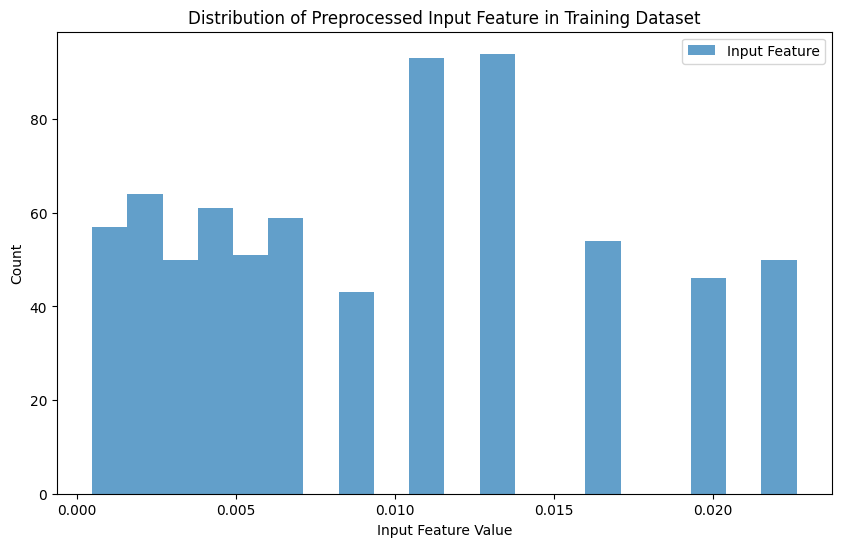

In [5]:
# View first few rows
print(X_train.head())

# Plot distributions of a specific feature
plt.figure(figsize=(10, 6))
plt.hist(X_train['Input Feature'], bins=20, alpha=0.7, label='Input Feature')
plt.title('Distribution of Preprocessed Input Feature in Training Dataset')
plt.xlabel('Input Feature Value')
plt.ylabel('Count')
plt.legend()
plt.show()


In [26]:
def calculate_cpu_usage_error_rate(y_actual, y_predicted):
    """
    Calculate the error rate for CPU usage predictions based on the criteria:
    If the predicted value falls in the integer range of the actual value, then it is not an error.
    
    Args:
        y_actual (array-like): The actual CPU usage values.
        y_predicted (array-like): The predicted CPU usage values.
        
    Returns:
        float: The error rate.
    """
    errors = 0
    for actual, predicted in zip(y_actual, y_predicted):
        # Check if predicted falls outside the integer range of actual
        if not (int(actual) <= predicted < int(actual) + 1):
            errors += 1
    
    error_rate = errors / len(y_actual)
    return error_rate


In [28]:
# Ensure y_test_cpu_usage and y_pred_cpu are 1-dimensional numpy arrays
y_test_cpu_usage = ensure_1d_array(y_test_cpu_usage)
y_pred_cpu = ensure_1d_array(y_pred_cpu)

# Calculate the error rate
cpu_usage_error_rate = calculate_cpu_usage_error_rate(y_test_cpu_usage, y_pred_cpu)

print(f"CPU Usage Error Rate: {cpu_usage_error_rate:.2%}")


CPU Usage Error Rate: 10.36%


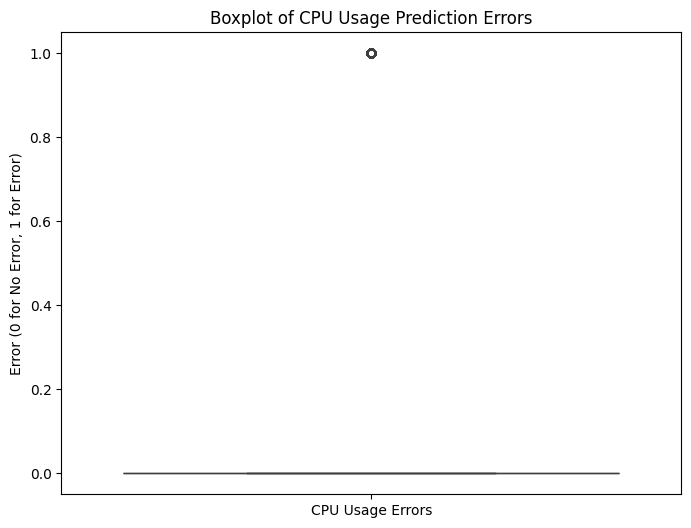

CPU Usage Error Rate: 10.36%


In [29]:
def compute_cpu_usage_errors(y_actual, y_predicted):
    """
    Compute individual errors for CPU usage predictions and the error rate.
    
    Args:
        y_actual (array-like): The actual CPU usage values.
        y_predicted (array-like): The predicted CPU usage values.
        
    Returns:
        errors (list): A list of errors (0 for no error, 1 for error) for each data point.
        float: The error rate.
    """
    errors = []
    for actual, predicted in zip(y_actual, y_predicted):
        # Error is 0 if predicted is within the integer range of actual, 1 otherwise
        error = 0 if int(actual) <= predicted < int(actual) + 1 else 1
        errors.append(error)
    
    error_rate = sum(errors) / len(y_actual)
    return errors, error_rate

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test_cpu_usage and y_pred_cpu are available from your model's predictions

# Compute errors and error rate
cpu_usage_errors, cpu_usage_error_rate = compute_cpu_usage_errors(y_test_cpu_usage, y_pred_cpu)

# Plot the boxplot of errors
plt.figure(figsize=(8, 6))
sns.boxplot(data=cpu_usage_errors)
plt.title('Boxplot of CPU Usage Prediction Errors')
plt.ylabel('Error (0 for No Error, 1 for Error)')
plt.xticks([0], ['CPU Usage Errors'])  # Adjust x-ticks for clarity
plt.show()

# Optionally, print the error rate as well
print(f"CPU Usage Error Rate: {cpu_usage_error_rate:.2%}")


In [7]:
mydf = pd.read_csv('./cpu_error_list.csv')
mydf.head()

,0
0,0.028524
1,0.190193
2,0.003644
3,0.012461
4,0.003492


/tmp/ipykernel_187832/149764121.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='ErrorRate', data=combined_data, palette="Set2", showfliers=True)


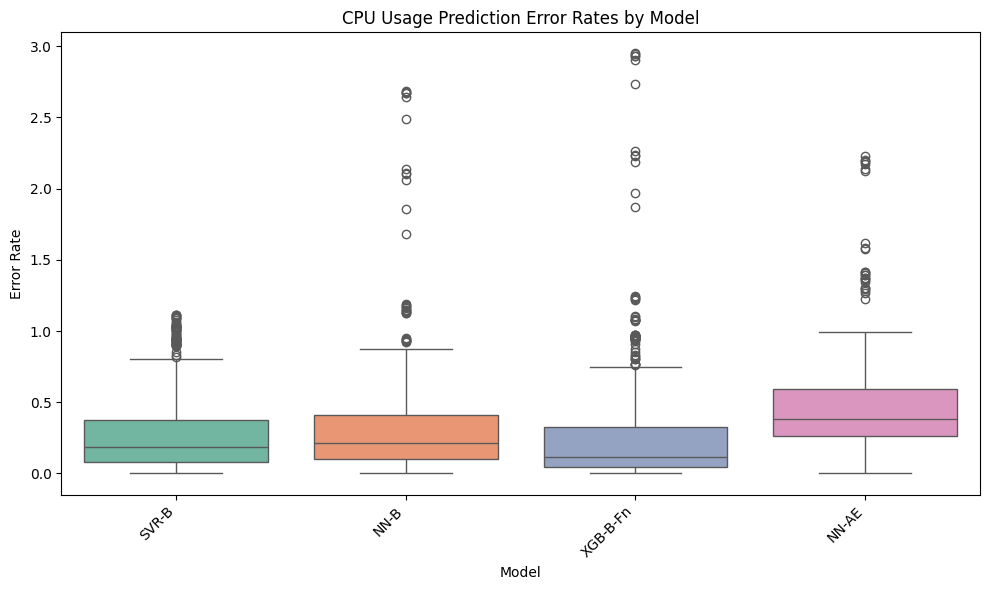

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Abbreviated model names for the x-axis
file_paths = {
    'SVR-B': './logs/bertEncoder/errors/SVR_cpu_error_list.csv',  # SVR with BERT
    'NN-B': './logs/bertEncoder/errors/BasicNN_cpu_error_list.csv',  # NN with BERT
    'XGB-B-Fn': './logs/bertEncoder/errors/XGBoost_nameInclude_cpu_error_list.csv',  # XGBoost with BERT and Function Name
    'NN-AE': './ahmad/cpu_usage_error_list.csv',  # NN2 with Autoencoder
}

# Initialize an empty DataFrame
combined_data = pd.DataFrame()

# Process data
for model_name, file_path in file_paths.items():
    model_data = pd.read_csv(file_path, header=None)
    model_data.columns = ['ErrorRate']
    model_data['Model'] = model_name
    combined_data = pd.concat([combined_data, model_data])

# Create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='ErrorRate', data=combined_data, palette="Set2", showfliers=True)
plt.title('CPU Usage Prediction Error Rates by Model')
plt.ylabel('Error Rate')
plt.xlabel('Model')

# Improve x-axis labels
plt.xticks(rotation=45, ha='right')

plt.tight_layout()  # Adjust layout for the plot
plt.savefig('cpu_usage_error_rates.png')  # Save the plot as an image


/tmp/ipykernel_187832/271280011.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette="Set2")


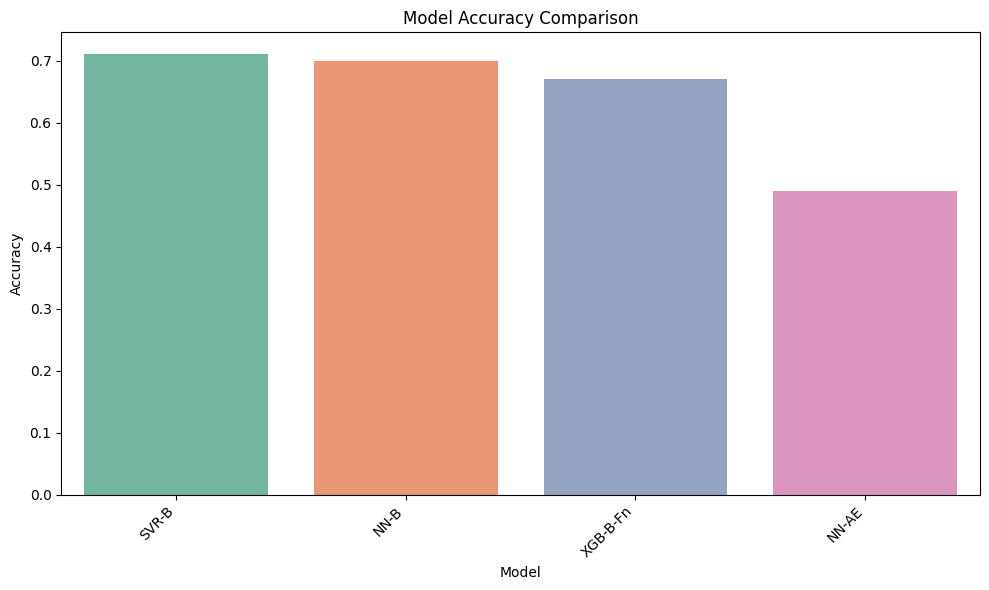

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Placeholder accuracy data for each model
# Note: Replace these values with your actual model accuracy data
accuracy_data = {
    'Model': ['RandomForest', 'XGBoost', 'SVR', 'NN', 'DecisionTree', 'LinearRegression'],
    'Accuracy': [0.71, 0.70, 0.67, 0.49]  # Example accuracies; replace with your data
}

# Convert to DataFrame
accuracy_df = pd.DataFrame(accuracy_data)

# Create a bar plot to visualize the accuracy across different models
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette="Set2")
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')

# Improve x-axis labels
plt.xticks(rotation=45, ha='right')

plt.tight_layout()  # Adjust layout for the plot
plt.savefig('model_accuracy_comparison.png')  # Save the plot as an image


/tmp/ipykernel_187832/1486439326.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='ErrorRate', data=combined_data, palette="Set3", showfliers=True)


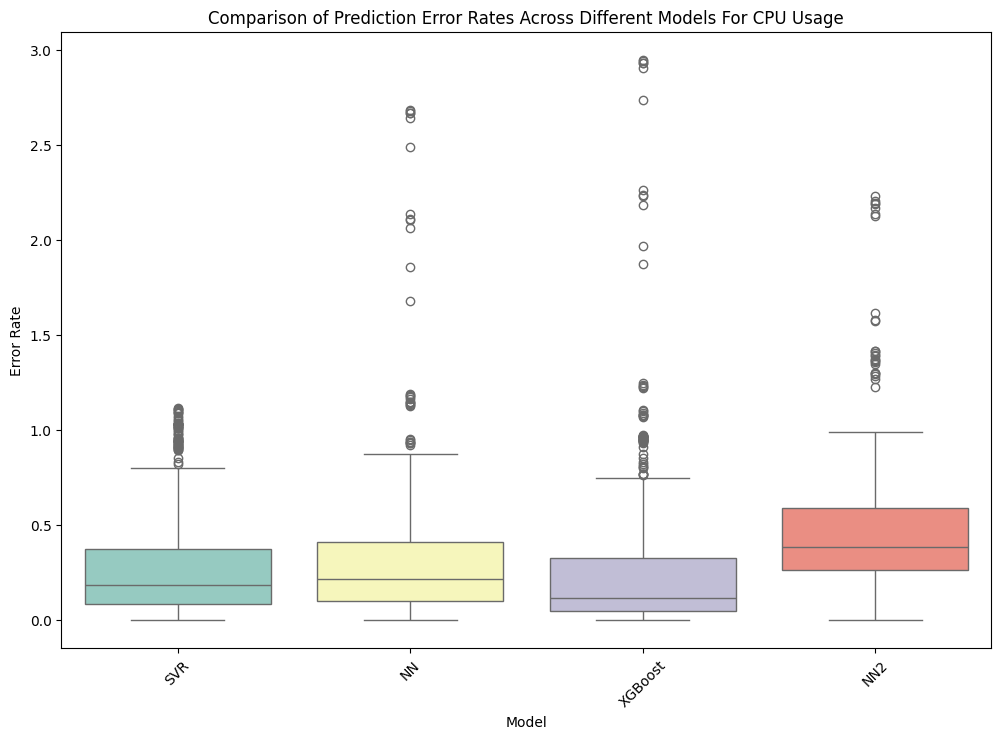

In [9]:
# Create a boxplot to visualize the error rates across different models
plt.figure(figsize=(12, 8))
sns.boxplot(x='Model', y='ErrorRate', data=combined_data, palette="Set3", showfliers=True)
plt.title('Comparison of Prediction Error Rates Across Different Models For CPU Usage')
plt.ylabel('Error Rate')
plt.xlabel('Model')
plt.xticks(rotation=45)  # Rotate model names for better readability
# plt.show()
plt.savefig('./figures/cpu_error_rate.png')


/tmp/ipykernel_121632/4274833967.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='ErrorRate', data=combined_data, palette="Set3")


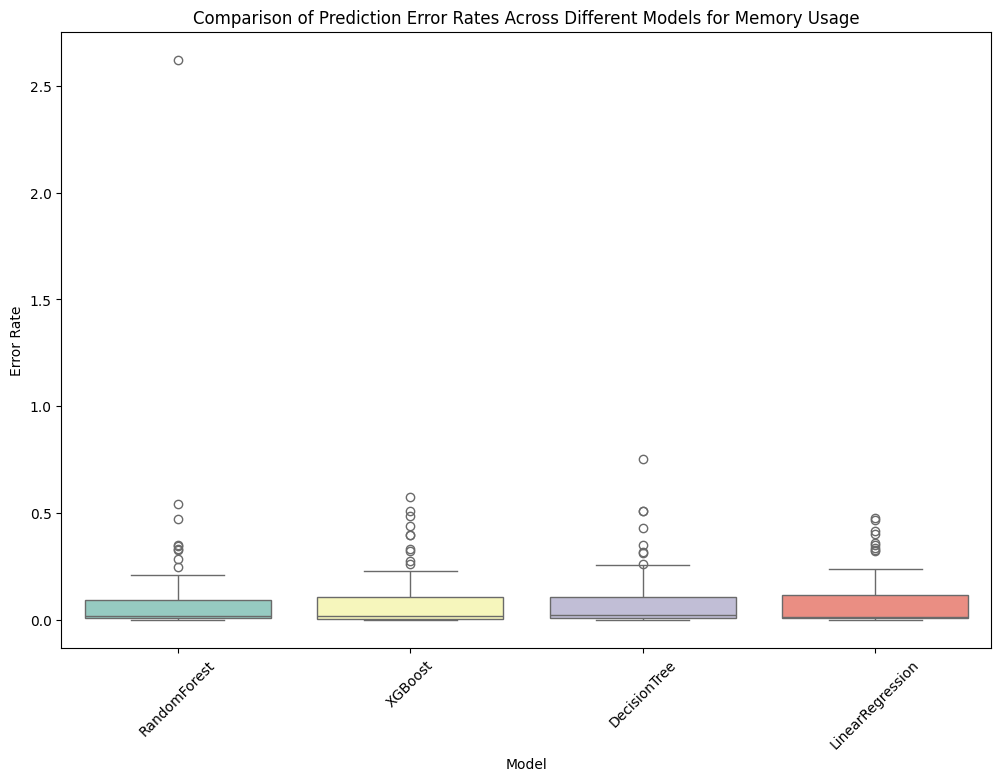

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
#read from error_file as a txt file
# file_paths = {
#     'RandomForest': './logs/errors/RandomForest_memory_error_list.csv',
#     'XGBoost': './logs/errors/XGBoost_memory_error_list.csv',
#     'SVR': './logs/errors/SVR_memory_error_list.csv',
#     'NN': './logs/errors/BasicNN_memory_error_list.csv',
#     'DecisionTree': './logs/errors/DecisionTree_memory_error_list.csv',
#     'LinearRegression': './logs/errors/LinearRegression_memory_error_list.csv'
# }

file_paths = {
    'RandomForest': './logs/aes/errors/RandomForest_cpu_error_list.csv',
    'XGBoost': './logs/aes/errors/XGBoost_cpu_error_list.csv',
    # 'SVR': './logs/aes/errors/SVR_cpu_error_list.csv',
    # 'NN': './logs/aes/errors/BasicNN_cpu_error_list.csv',
    'DecisionTree': './logs/aes/errors/DecisionTree_cpu_error_list.csv',
    'LinearRegression': './logs/aes/errors/LinearRegression_cpu_error_list.csv'
}

# Initialize an empty DataFrame to combine all models' data
combined_data = pd.DataFrame()

# Loop through the file paths, read each CSV, add a model column, and append to the combined DataFrame
for model_name, file_path in file_paths.items():
    model_data = pd.read_csv(file_path, header=None)  # Assuming there's no header based on the first file structure
    model_data.columns = ['ErrorRate']  # Naming the column for clarity
    model_data['Model'] = model_name  # Add a column with the model name
    combined_data = pd.concat([combined_data, model_data])

# Display the first few rows of the combined DataFrame to verify the structure
# combined_data.head()



# Create a boxplot to visualize the error rates across different models
plt.figure(figsize=(12, 8))
sns.boxplot(x='Model', y='ErrorRate', data=combined_data, palette="Set3")
plt.title('Comparison of Prediction Error Rates Across Different Models for Memory Usage')
plt.ylabel('Error Rate')
plt.xlabel('Model')
plt.xticks(rotation=45)  # Rotate model names for better readability
# plt.show()
plt.savefig('./figures/memory_error_rate.png')


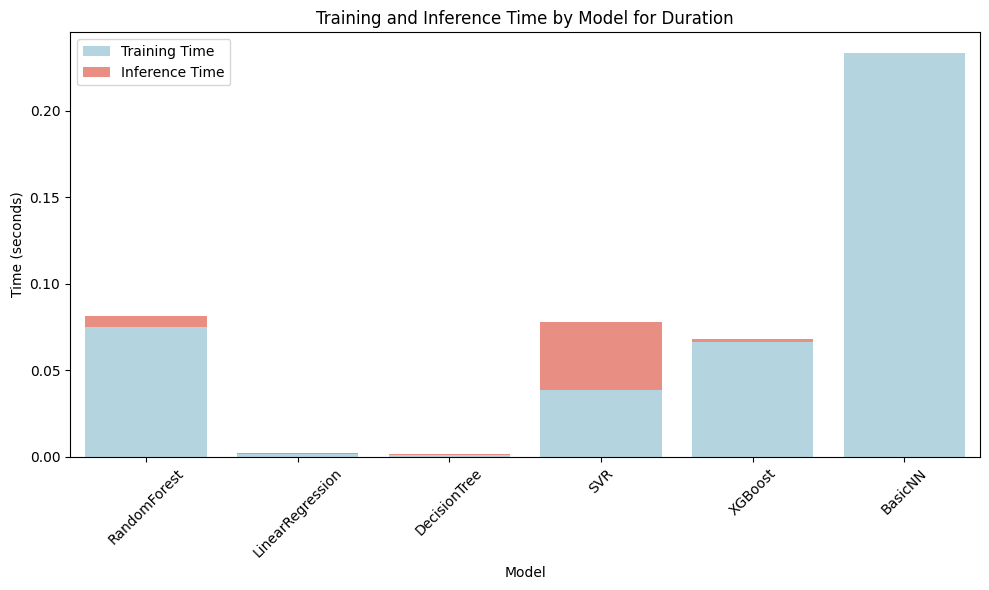

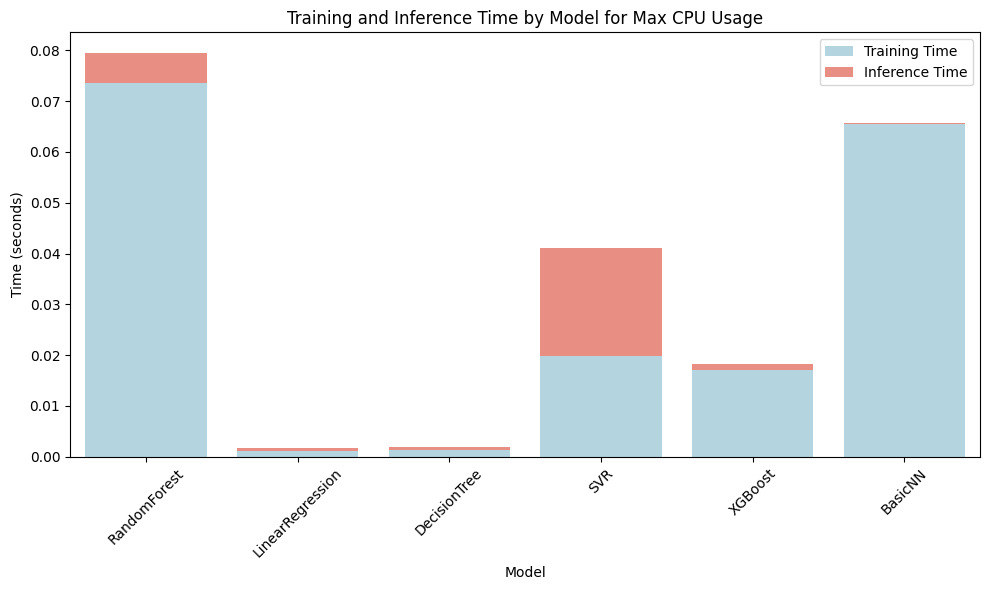

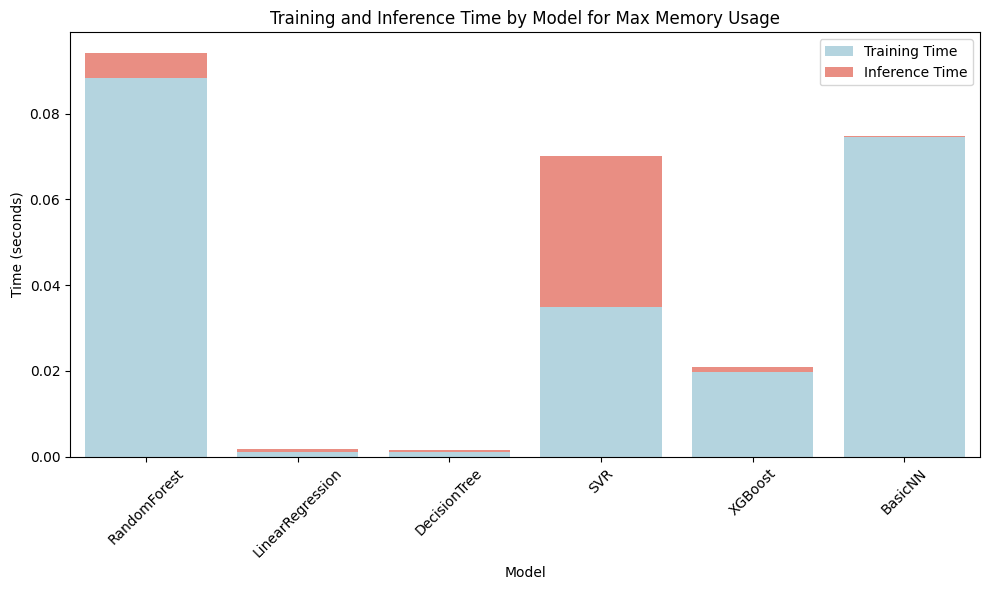

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the time statistics
time_df = pd.read_csv('./logs/times/model_time_statistics.csv')

# Set the color palette to use
sns.set_palette("Paired")

# Get unique targets
targets = time_df['Target'].unique()

for target in targets:
    # Filter the dataframe for the current target
    target_df = time_df[time_df['Target'] == target]
    
    # Create a new figure for the target
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plotting with seaborn for better color control
    # Training Time
    sns.barplot(x='Model', y='Training Time', data=target_df, label='Training Time', ax=ax, color='lightblue')
    # Inference Time - Note: We need to calculate the bottom position for each bar to stack them.
    bottom_pos = target_df['Training Time'].values
    sns.barplot(x='Model', y='Inference Time', data=target_df, label='Inference Time', ax=ax, bottom=bottom_pos, color='salmon')

    ax.set_ylabel('Time (seconds)')
    ax.set_title(f'Training and Inference Time by Model for {target}')
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'./figures/{target}_time_statistics.png')


In [13]:
import json
import torch
from transformers import BertTokenizer, BertModel

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


with open('inputs/assa.json', 'r') as f:
    data = json.load(f)

# Extract text from each entry under the "data" field
texts = []
for key, value in data['data'].items():
    text = " ".join([str(v) for k, v in value.items()])
    texts.append(text)

# Tokenize and encode the texts
tokenized_texts = [tokenizer(text, padding=True, truncation=True, return_tensors="pt") for text in texts]

# Perform embedding
embeddings = []
with torch.no_grad():
    for inputs in tokenized_texts:
        outputs = model(**inputs)
        # Extract the embeddings from the last layer of BERT model
        last_hidden_states = outputs.last_hidden_state
        # Here, you can take the mean or max pooling over the token embeddings to get a single vector representing the entire text
        text_embedding = torch.mean(last_hidden_states, dim=1).squeeze().numpy()
        embeddings.append(text_embedding)

# embeddings now contains the BERT embeddings for each text under the "data" field


/home/peiman/miniconda3/envs/nimbus/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
print(len(embeddings[0]))
print(len(embeddings))
type(embeddings[0][0])

768
3


numpy.float32